In [20]:
#Importing the necessary libraries

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import torch
import numpy as np
import pickle
import open3d as o3d
import matplotlib.pyplot as plt
from model.resunet import ResUNetBN2C
from util.visualization import get_colored_point_cloud_feature
from numpy import linalg as LA
from util.feature_extraction import stl2ply_convert, feature_extract
from util.misc import sort_list, zero_pad
from util.spp_layer import  SpatialPyramidPooling
from collections import Counter
from tqdm import tqdm
from tensorflow.python.keras.layers import Layer
import tensorflow.keras.backend as K
K.image_data_format()

'channels_last'

In [21]:
# Unpickling the features previously extracted

with open("data/names_paths_features_featurenet.dat", "rb") as f:
    file_names, file_paths, features = pickle.load(f)

In [22]:
# Checking the number of classes and the data count
families = Counter(file_names)
print("Number of classes:",len(families))
print("\n",families)

Number of classes: 24

 Counter({'9_triangular_pocket': 1000, '20_v_circular_end_blind_slot': 1000, '11_circular_end_pocket': 1000, '4_rectangular_passage': 1000, '21_h_circular_end_blind_slot': 1000, '0_Oring': 1000, '16_2sides_through_step': 1000, '2_blind_hole': 1000, '23_6sides_pocket': 1000, '7_rectangular_through_slot': 1000, '6_triangular_through_slot': 1000, '17_slanted_through_step': 1000, '22_6sides_passage': 1000, '8_rectangular_blind_slot': 1000, '1_through_hole': 1000, '5_circular_through_slot': 1000, '3_triangular_passage': 1000, '15_rectangular_through_step': 1000, '19_round': 1000, '14_rectangular_blind_step': 1000, '18_chamfer': 1000, '13_circular_blind_step': 1000, '12_triangular_blind_step': 1000, '10_rectangular_pocket': 1000})


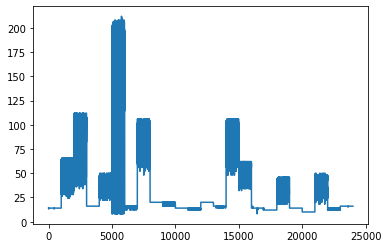

In [23]:
# Visualizing the distrubtion of feaure dimensions along all the 24 classes
shape_list = list()
for i in range(0,len(features)):
    f = features[i]
    shape_list.append(f.shape[0])
xs = [x for x in range(len(shape_list))]
plt.plot(xs,shape_list)

In [24]:
# Checking maximum feature dimension
max_val=0

for i in range(0,len(features)):
    f = features[i]
    max = np.maximum(f.shape[0],f.shape[1])
    if(max > max_val):
        max_val = max
print(max_val)

212


In [25]:
# Zero padding all the vectors to max value
def zero_pad(x):
    shape_pad = max_val 
    x1 = np.zeros([shape_pad,32])
    x1[:x.shape[0],:x.shape[1]] = x
    return x1
max_val = 240
for j in range(0,len(features)):
    z = zero_pad(features[j])
    features[j] =z

In [26]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical

X = np.asarray(features)

# one-hot encoding
Y_set = set(file_names)
Y_list = (list(Y_set))
mapping = {}
family = list()

# 24 unique features
for x in range(len(Y_list)):
  mapping[Y_list[x]] = x

# mapping to corresponding category
for x in range(len(file_names)):
  family.append(mapping[file_names[x]])

Y = to_categorical(family)
Y = np.array(Y)

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)
# val,test = 0.5 x 0.3 = 0.15

In [28]:
# Convering to tensors
x_train = tf.convert_to_tensor(x_train, dtype=None, dtype_hint=None, name=None)
x_val = tf.convert_to_tensor(x_val, dtype=None, dtype_hint=None, name=None)
x_test = tf.convert_to_tensor(x_test, dtype=None, dtype_hint=None, name=None)
y_train = tf.convert_to_tensor(y_train, dtype=None, dtype_hint=None, name=None)
y_val = tf.convert_to_tensor(y_val, dtype=None, dtype_hint=None, name=None)
y_test = tf.convert_to_tensor(y_test, dtype=None, dtype_hint=None, name=None)

In [29]:
# Reshaping tensor for input to neural net

x_train = tf.reshape(x_train, [len(x_train),max_val,32,1])
x_val = tf.reshape(x_val, [len(x_val),max_val,32,1])
x_test = tf.reshape(x_test, [len(x_test),max_val,32,1])

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Activation, MaxPooling2D, Dense, Dropout


# Minimizes Tensorflow Logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

BATCH_SIZE = 64
NUM_CHANNELS = 1
NUM_CLASSES = 24

def makeModel():
    model = Sequential()

    # MODEL 1
    # uses tensorflow ordering. Note that we leave the image size as None to allow multiple image sizes
    model.add(Convolution2D(32, 3, NUM_CHANNELS, padding='same', input_shape=(max_val,32,1)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, 3, NUM_CHANNELS, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(64, 3, NUM_CHANNELS, padding='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, NUM_CHANNELS, padding='same'))
    model.add(Activation('relu'))
    model.add(SpatialPyramidPooling([1, 2, 4]))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))

    return model

In [31]:
tf.executing_eagerly = False

In [32]:
model=makeModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 240, 32, 32)       320       
_________________________________________________________________
activation_5 (Activation)    (None, 240, 32, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 240, 32, 32)       9248      
_________________________________________________________________
activation_6 (Activation)    (None, 240, 32, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 16, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 16, 64)       18496     
_________________________________________________________________
activation_7 (Activation)    (None, 120, 16, 64)      

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [36]:
#Running and Saving model

from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "model/pretrained/spp_featurenet.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(x_train, y_train, batch_size=16, epochs= 30, verbose=2,
                    validation_data=(x_val,y_val), shuffle=True, class_weight=None,
                    sample_weight=None, initial_epoch=0, steps_per_epoch=None, 
                    validation_steps=None, validation_freq=1, max_queue_size=10,
                    workers=1,callbacks=callbacks_list)

Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.92750, saving model to model/pretrained/spp_featurenet2.h5
1050/1050 - 13s - loss: 0.1514 - accuracy: 0.9355 - val_loss: 0.1629 - val_accuracy: 0.9275
Epoch 2/30

Epoch 00002: val_accuracy improved from 0.92750 to 0.92778, saving model to model/pretrained/spp_featurenet2.h5
1050/1050 - 13s - loss: 0.1288 - accuracy: 0.9446 - val_loss: 0.1695 - val_accuracy: 0.9278
Epoch 3/30

Epoch 00003: val_accuracy improved from 0.92778 to 0.93194, saving model to model/pretrained/spp_featurenet2.h5
1050/1050 - 13s - loss: 0.1214 - accuracy: 0.9477 - val_loss: 0.1548 - val_accuracy: 0.9319
Epoch 4/30

Epoch 00004: val_accuracy improved from 0.93194 to 0.93250, saving model to model/pretrained/spp_featurenet2.h5
1050/1050 - 13s - loss: 0.1156 - accuracy: 0.9504 - val_loss: 0.1563 - val_accuracy: 0.9325
Epoch 5/30

Epoch 00005: val_accuracy improved from 0.93250 to 0.93500, saving model to model/pretrained/spp_featurenet2.h5
1050/1050 - 13s

In [ ]:
#loading the model

from  tensorflow.keras.models import load_model
model = load_model("model/pretrained/spp_featurenet.h5",custom_objects={'SpatialPyramidPooling': SpatialPyramidPooling})

In [38]:
# Defining a temperory model for spp output

from  tensorflow.keras.models import Model
layer_name = 'my_layer'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('spatial_pyramid_pooling').output)

## Finding Accuracy

In [39]:
# Finding accuracy on test set
spp_train = intermediate_layer_model.predict(x_train)

top5_acc =0
top1_acc =0
top5_lbl = list()
sim_list = list()
null_index = list()
classes = 24

for i in tqdm (range(0,len(x_test))):
    sim_list.clear()
    #test_feat = spp_test[i]
    test_feat = tf.reshape(x_test[i],[1,max_val,32,1])
    spp_test = intermediate_layer_model.predict(test_feat)
    y_t = y_test[i]
    for j in range(0,classes):
        if(y_t[j].numpy()==1.0):
            test_lbl = Y_list[j]  
    for k in range(0,len(x_train)):  
        #train_feat = tf.reshape(x_train[i],[1,max_val,32,1])
        sim_list.append(abs(np.linalg.norm(spp_train[k]-spp_test)))
    id = list(range(0,len(x_train)))
    Sim_models_id = [x for _,x in sorted(zip(sim_list,id))]
    top5 = (Sim_models_id[0:5])
    top5_lbl.clear()
    for l in range(0,5): 
        yi = y_train[top5[l]]
        for m in range(0,classes):
            if ((yi[m].numpy())==1.0):
                top5_lbl.append(Y_list[m])
    if(test_lbl in top5_lbl):
        top5_acc+=1
        
    if (top5_lbl):
        if(test_lbl == top5_lbl[0]):
            top1_acc+=1
    else:
        null_index.append(i)
        
print("Accuracy for ",len(x_test),"testing files is ",top1_acc/len(x_test))
print("Top 5 accuracy for ",len(x_test),"testing files is ",top5_acc/len(x_test))
print(len(null_index))

100%|██████████| 3600/3600 [09:57<00:00,  6.02it/s]

Accuracy for  3600 testing files is  0.9283333333333333
Top 5 accuracy for  3600 testing files is  0.9852777777777778
0


## Retrieving similar features from the dataset for a sample file

In [41]:
#loading stl dataset paths 

db_folder = "data/stl"
os.path.abspath(db_folder)
ind = 0
stl_file_path = list()
sub_folders = os.listdir(db_folder)
for sub_folder in sub_folders:
        sub_folder_path = os.path.join(db_folder, sub_folder)
        stl_files = os.listdir(sub_folder_path)
        for stl_file in stl_files:
            if stl_file.endswith(".STL"):
                stl_file_path.append(os.path.join(sub_folder_path, stl_file))
                ind+=1

In [42]:
def get_spp_out(feat):
    test_feat = tf.reshape(feat,[1,max_val,32,1])
    spp_test = intermediate_layer_model.predict(test_feat)
    return spp_test    

In [43]:
#test file

test_id = 1990
print("Test file\n","\nID:\t",test_id,"\tFamily:\t",file_names[test_id])
test_feat = zero_pad(features[test_id])
spp_test_feat = get_spp_out(test_feat)

Test file
 
ID:	 1990 	Family:	 20_v_circular_end_blind_slot


In [44]:
#comparing similaity between one test file and all the features individually

n_files = len(features)

sim_list = list()
for i in range(0,n_files):
    if(i!=test_id):
        feat = zero_pad(features[i])
        feat = tf.reshape(feat,[1,max_val,32,1])
        spp_feat = intermediate_layer_model.predict(feat)
        sim_list.append(abs(np.linalg.norm(spp_feat - spp_test_feat)))
    else:
        sim_list.append(float("inf"))

In [45]:
id = list(range(0,n_files))

Similar_models_id = [x for _,x in sorted(zip(sim_list,id))]
top_5 = (Similar_models_id[0:5])
top_5

[1256, 1143, 1030, 1284, 1406]

In [46]:
# Visualiztion of the CAD files
from solid import*
import viewscad
r = viewscad.Renderer()
print("Test file\n","\nID:\t",test_id,"\tFamily:\t",file_names[test_id])
r.render_stl(stl_file_path[test_id])
print("\nTop-5 similar models and their IDs\n")
for i in range(0,5): 
    yi = file_names[top_5[i]]
    print("ID:\t",top_5[i],"\tFamily:\t",yi)
    r.render_stl(stl_file_path[top_5[i]])

Test file
 
ID:	 1990 	Family:	 20_v_circular_end_blind_slot


/home/ubuntu/environments/s4engine/lib/python3.8/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)



Top-5 similar models and their IDs

ID:	 1256 	Family:	 20_v_circular_end_blind_slot


ID:	 1143 	Family:	 20_v_circular_end_blind_slot


ID:	 1030 	Family:	 20_v_circular_end_blind_slot


ID:	 1284 	Family:	 20_v_circular_end_blind_slot


ID:	 1406 	Family:	 20_v_circular_end_blind_slot
